In [221]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz, process
import seaborn as sns
import matplotlib.pyplot as plt

In [268]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [223]:
df = pd.read_excel("descargas/GSAF5.xls")

In [224]:
from xlrd import open_workbook
wb = open_workbook('descargas/GSAF5.xls', formatting_info=True)
sheet = wb.sheet_by_index(0)
bgcol=[]
for row in range(1,sheet.nrows):
    column = 1
    cell = sheet.cell(row, column)  
    fmt = wb.xf_list[cell.xf_index]
    bgcol.append(fmt.background.pattern_colour_index)


In [225]:
wb.colour_map[64]

In [226]:
set(bgcol)

{8, 26, 42, 43, 44, 47, 53, 64}

In [227]:
# Esto hecho a mano
paleta = {
    8: "Orange",
    26: "Tan",
    42: "Green",
    43: "Tan",
    44: "Blue",
    47: "Tan",
    53: "Orange",
    64: "White"
}

In [228]:
cell_colors = [paleta[x] for x in bgcol]

In [229]:
df["cell_color"] = pd.Series(cell_colors)

In [230]:
map_tipo_incidente = {
    "Tan": "Unprovoked Incidents",
    "Orange": "Provoked Incidents",
    "Green": "Attacks on Boats",
    "Yellow": "Air / Sea Disasters",
    "Blue": "Questionable Incidents",
    "White": "Other"
}

In [231]:
df["tipo_incidente"] = df["cell_color"].map(map_tipo_incidente)

In [232]:
df["tipo_incidente"].value_counts()

Unprovoked Incidents      5387
Provoked Incidents         638
Questionable Incidents     585
Attacks on Boats           363
Name: tipo_incidente, dtype: int64

In [233]:
df["Type"].value_counts(dropna=False)

Unprovoked             5135
Provoked                636
Invalid                 552
Watercraft              355
Sea Disaster            242
Questionable             22
NaN                      18
Boat                      7
 Provoked                 2
?                         1
Unconfirmed               1
Unverified                1
Under investigation       1
Name: Type, dtype: int64

In [234]:
df["Type"] = df["Type"].str.strip()
df["Type"] = df["Type"].str.upper()
df["Type"] = df["Type"].str.replace(r'[^\w\s&\/]', '', regex=True)

df["Type"].value_counts(dropna=False)

UNPROVOKED             5135
PROVOKED                638
INVALID                 552
WATERCRAFT              355
SEA DISASTER            242
QUESTIONABLE             22
NaN                      18
BOAT                      7
                          1
UNCONFIRMED               1
UNVERIFIED                1
UNDER INVESTIGATION       1
Name: Type, dtype: int64

In [235]:
df = df[df['Type'] != 'INVALID']

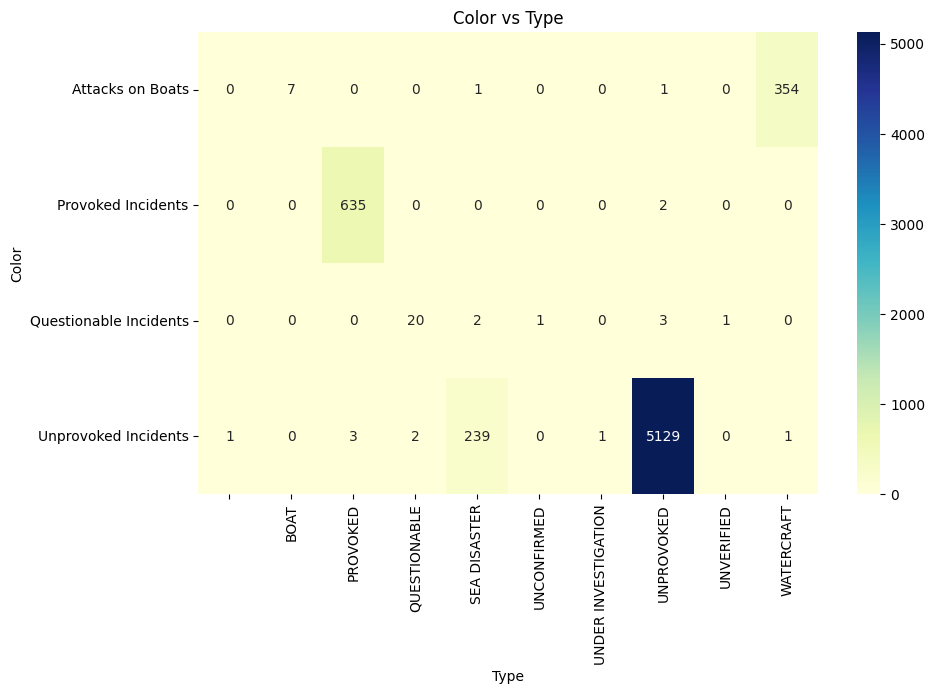

In [236]:
def plot_heatmap(df):
    contingency_table = pd.crosstab(df['tipo_incidente'], df['Type'])
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
    plt.title("Color vs Type")
    plt.xlabel("Type")
    plt.ylabel("Color")
    plt.show()

plot_heatmap(df)

In [237]:
# Unificamos BOAT y WATERCRAFT
df['Type'] = df['Type'].replace(['WATERCRAFT'], 'BOAT')

# Todos los que no caen en las categorias pedidas los metemos abajo de others, igual son poquitos
df['Type'] = df['Type'].replace(['UNCONFIRMED', '', 'UNVERIFIED', 'UNDER INVESTIGATION'], 'OTHERS')

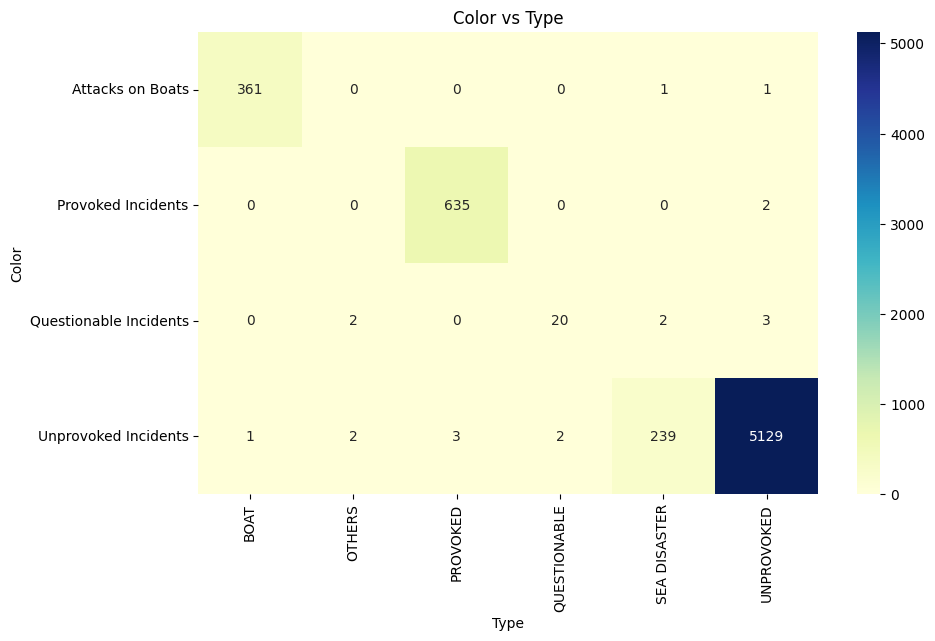

In [238]:
plot_heatmap(df)

In [239]:
# De los que estan en OTHERS, si el color nos da info tomamos eso y lo estandarizamos
tipo_incidente_a_type = { 
    'Unprovoked Incidents': 'UNPROVOKED',
    'Provoked Incidents': 'PROVOKED',
    'Questionable Incidents': 'QUESTIONABLE',
    'Attacks on Boats': 'BOAT'
}
df.loc[df['Type'] == 'OTHERS', 'Type'] = df['tipo_incidente'].map(tipo_incidente_a_type)

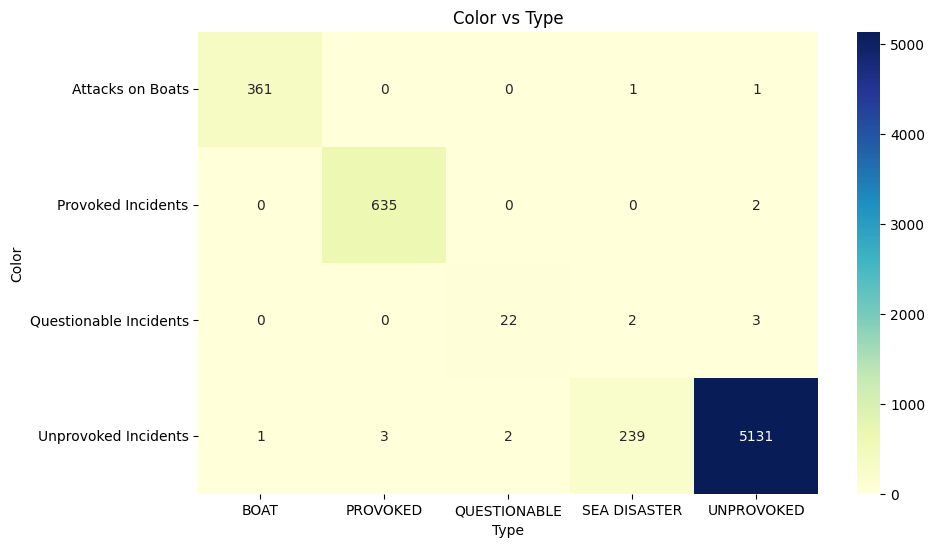

In [240]:
plot_heatmap(df)

In [241]:
# Finalmente, en los que hay diferencia creemos lo que dice la columna, que es menos error prone que un color
# y tiene cosas como sea disaster que 
df["Type"].value_counts()

UNPROVOKED      5137
PROVOKED         638
BOAT             362
SEA DISASTER     242
QUESTIONABLE      24
Name: Type, dtype: int64

# Países

Limpieza de datos de ataques por país.

En este caso nos interesa poder responder la pregunta: **¿cuántos ataques se registraron por país?**

Para ello, nos interesaría contar con una fuente confiable de países sobre la cual asignar a cada registro del dataset.

Definimos usar el dataset https://github.com/google/dspl/blob/master/samples/google/canonical/countries.csv que contiene nombres de países incluídos en el Dataset Publishing Language de Google.

In [242]:
# Vemos cuantos nulos hay
df["Country"].isnull().sum() / df.shape[0]

0.0070082541660177545

Luego definimos eliminar los registros sin dato de país

In [243]:
df.dropna(subset=["Country"], inplace=True)

In [244]:
# verificamos que no haya nulos
df["Country"].isnull().sum() == 0

True

En lo que sigue intentamos estandarizar y limpiar los nombres de países

In [245]:
# Vemos recuentro por pais
df["Country"].value_counts()

USA                                      2356
AUSTRALIA                                1361
SOUTH AFRICA                              532
PAPUA NEW GUINEA                          134
NEW ZEALAND                               131
BAHAMAS                                   131
BRAZIL                                    112
MEXICO                                     92
FIJI                                       67
NEW CALEDONIA                              64
REUNION                                    60
ITALY                                      60
PHILIPPINES                                59
CUBA                                       46
EGYPT                                      46
MOZAMBIQUE                                 42
INDIA                                      40
FRENCH POLYNESIA                           36
SPAIN                                      36
PANAMA                                     31
JAPAN                                      31
SOLOMON ISLANDS                   

Rápidamente encontramos algunos registros en minúscula, otros en mayúscula, con espacios en blanco al inicio o al final. Modificamos todos esos casos.

In [246]:
def normalize_countries(df):
    df["Country"] = df["Country"].str.strip()
    df["Country"] = df["Country"].str.upper()
    df['Country'] = df['Country'].str.replace(r'[^\w\s&\/]', '', regex=True)

In [247]:
normalize_countries(df)

In [248]:
sorted(df["Country"].dropna().unique())

['ADMIRALTY ISLANDS',
 'AFRICA',
 'ALGERIA',
 'AMERICAN SAMOA',
 'ANDAMAN / NICOBAR ISLANDAS',
 'ANDAMAN ISLANDS',
 'ANGOLA',
 'ANTIGUA',
 'ARGENTINA',
 'ARUBA',
 'ASIA',
 'ATLANTIC OCEAN',
 'AUSTRALIA',
 'AZORES',
 'BAHAMAS',
 'BAHREIN',
 'BANGLADESH',
 'BARBADOS',
 'BAY OF BENGAL',
 'BELIZE',
 'BERMUDA',
 'BETWEEN PORTUGAL & INDIA',
 'BRAZIL',
 'BRITISH ISLES',
 'BRITISH NEW GUINEA',
 'BRITISH OVERSEAS TERRITORY',
 'BRITISH WEST INDIES',
 'BURMA',
 'CANADA',
 'CAPE VERDE',
 'CARIBBEAN SEA',
 'CENTRAL PACIFIC',
 'CEYLON',
 'CEYLON SRI LANKA',
 'CHILE',
 'CHINA',
 'COAST OF AFRICA',
 'COLOMBIA',
 'COLUMBIA',
 'COOK ISLANDS',
 'CORAL SEA',
 'COSTA RICA',
 'CRETE',
 'CROATIA',
 'CUBA',
 'CURACAO',
 'CYPRUS',
 'DIEGO GARCIA',
 'DJIBOUTI',
 'DOMINICAN REPUBLIC',
 'ECUADOR',
 'EGYPT',
 'EGYPT / ISRAEL',
 'EL SALVADOR',
 'ENGLAND',
 'EQUATORIAL GUINEA / CAMEROON',
 'FALKLAND ISLANDS',
 'FEDERATED STATES OF MICRONESIA',
 'FIJI',
 'FRANCE',
 'FRENCH POLYNESIA',
 'GABON',
 'GEORGIA',
 'GHANA',


Vemos que los casos con '/' indican que el incidente ocurrió en la frontera entre dos países

In [249]:
# Vemos cuantos incidentes en fronteras hay
df["Country"].str.contains("/").sum() / df["Country"].notnull().sum()

0.001097867001254705

In [250]:
# Definimos asignar los incidentes en fronteras a ambos paises
df["Country"] = df["Country"].str.split("/")

In [251]:
# explode para que cada fila tenga un solo pais
df = df.explode('Country')

In [257]:
# volvemos a normalizar luego de explotar
normalize_countries(df)

Ahora leemos el archivo de países e intentamos asignar cada registro a un país reconocido

In [258]:
# leo datos de countries https://github.com/google/dspl/blob/master/samples/google/canonical/countries.csv
countries = pd.read_csv("descargas/countries.csv")

In [259]:
# me quedo con nombre de paises en formato mayuscula y sin espacios al principio y al final
standardized_countries = set(countries["name"].str.upper().str.strip())

In [260]:
standardized_countries

{'AFGHANISTAN',
 'ALBANIA',
 'ALGERIA',
 'AMERICAN SAMOA',
 'ANDORRA',
 'ANGOLA',
 'ANGUILLA',
 'ANTARCTICA',
 'ANTIGUA AND BARBUDA',
 'ARGENTINA',
 'ARMENIA',
 'ARUBA',
 'AUSTRALIA',
 'AUSTRIA',
 'AZERBAIJAN',
 'BAHAMAS',
 'BAHRAIN',
 'BANGLADESH',
 'BARBADOS',
 'BELARUS',
 'BELGIUM',
 'BELIZE',
 'BENIN',
 'BERMUDA',
 'BHUTAN',
 'BOLIVIA',
 'BOSNIA AND HERZEGOVINA',
 'BOTSWANA',
 'BOUVET ISLAND',
 'BRAZIL',
 'BRITISH INDIAN OCEAN TERRITORY',
 'BRITISH VIRGIN ISLANDS',
 'BRUNEI',
 'BULGARIA',
 'BURKINA FASO',
 'BURUNDI',
 'CAMBODIA',
 'CAMEROON',
 'CANADA',
 'CAPE VERDE',
 'CAYMAN ISLANDS',
 'CENTRAL AFRICAN REPUBLIC',
 'CHAD',
 'CHILE',
 'CHINA',
 'CHRISTMAS ISLAND',
 'COCOS [KEELING] ISLANDS',
 'COLOMBIA',
 'COMOROS',
 'CONGO [DRC]',
 'CONGO [REPUBLIC]',
 'COOK ISLANDS',
 'COSTA RICA',
 'CROATIA',
 'CUBA',
 'CYPRUS',
 'CZECH REPUBLIC',
 "CÔTE D'IVOIRE",
 'DENMARK',
 'DJIBOUTI',
 'DOMINICA',
 'DOMINICAN REPUBLIC',
 'ECUADOR',
 'EGYPT',
 'EL SALVADOR',
 'EQUATORIAL GUINEA',
 'ERITREA',

Nos interesa saber cuantos registros incluyen un país válido

In [264]:
df["is_valid_country"] = df["Country"].isin(standardized_countries)

In [265]:
ratio_registros_con_pais_valido = df["is_valid_country"].sum() / len(df)
print(f"Registros con pais válido: {ratio_registros_con_pais_valido * 100:.2f} %")

Registros con pais válido: 58.51 %


Lo que sigue intenta imputar los registros inválidos en algunos de los países reconocidos

In [274]:
# Vemos que países no son válidos
sorted(df[~df["is_valid_country"]]["Country"].unique())

['ADMIRALTY ISLANDS',
 'AFRICA',
 'ANDAMAN',
 'ANDAMAN ISLANDS',
 'ANTIGUA',
 'ASIA',
 'ATLANTIC OCEAN',
 'AZORES',
 'BAHREIN',
 'BAY OF BENGAL',
 'BETWEEN PORTUGAL & INDIA',
 'BRITISH ISLES',
 'BRITISH NEW GUINEA',
 'BRITISH OVERSEAS TERRITORY',
 'BRITISH WEST INDIES',
 'BURMA',
 'CARIBBEAN SEA',
 'CENTRAL PACIFIC',
 'CEYLON',
 'CEYLON SRI LANKA',
 'COAST OF AFRICA',
 'COLUMBIA',
 'CORAL SEA',
 'CRETE',
 'CURACAO',
 'DIEGO GARCIA',
 'ENGLAND',
 'FALKLAND ISLANDS',
 'FEDERATED STATES OF MICRONESIA',
 'GRAND CAYMAN',
 'GULF OF ADEN',
 'INDIAN OCEAN',
 'JAVA',
 'JOHNSTON ISLAND',
 'KOREA',
 'MALDIVE ISLANDS',
 'MEDITERRANEAN SEA',
 'MID ATLANTIC OCEAN',
 'MIDPACIFC OCEAN',
 'NEVIS',
 'NEW BRITAIN',
 'NEW GUINEA',
 'NICOBAR ISLANDAS',
 'NORTH ATLANTIC OCEAN',
 'NORTH PACIFIC OCEAN',
 'NORTH SEA',
 'NORTHERN ARABIAN SEA',
 'OCEAN',
 'OKINAWA',
 'PACIFIC OCEAN',
 'PERSIAN GULF',
 'RED SEA',
 'REUNION',
 'REUNION ISLAND',
 'ROATAN',
 'SAN DOMINGO',
 'SCOTLAND',
 'SOUTH ATLANTIC OCEAN',
 'SOU

Armamos manualmente dos estructuras de datos: una para mapear valores de Country a un país estandarizado, otro para eliminar registros no válidos

In [275]:
mapped_countries = {
    "TOBAGO": "TRINIDAD AND TOBAGO",
    "ENGLAND": "UNITED KINGDOM",
    "WESTERN SAMOA": "SAMOA",
    "SAN DOMINGO": "DOMINICAN REPUBLIC",
    "ROATAN": "HONDURAS",
    "ADMIRALTY ISLANDS": "PAPUA NEW GUINEA",
    "ANDAMAN": "MYANMAR [BURMA]",
    "ANDAMAN ISLANDS": "MYANMAR [BURMA]",
    "ANTIGUA": "ANTIGUA AND BARBUDA",
    "AZORES": "PORTUGAL",
    "BAHREIN": "BAHRAIN",
    "BRITISH NEW GUINEA": "PAPUA NEW GUINEA",
    "BURMA": "MYANMAR [BURMA]",
    "CEYLON": "SRI LANKA",
    "CEYLON SRI LANKA": "SRI LANKA",
    "CRETE": "GREECE",
    "CURACAO": "CURAÇAO",
    "ENGLAND": "UNITED KINGDOM",
    "FALKLAND ISLANDS": "FALKLAND ISLANDS [ISLAS MALVINAS]",
    "FEDERATED STATES OF MICRONESIA": "MICRONESIA",
    "GRAND CAYMAN": "CAYMAN ISLANDS",
    "GULF OF ADEN": "YEMEN",
    "JAVA": "INDONESIA",
    "JOHNSTON ISLAND": "UNITED STATES",
    "KOREA": "SOUTH KOREA",
    "MALDIVE ISLANDS": "MALDIVES",
    "NEVIS": "SAINT KITTS AND NEVIS",
    "NEW BRITAIN": "PAPUA NEW GUINEA",
    "NEW GUINEA": "PAPUA NEW GUINEA",
    "NICOBAR ISLANDAS": "INDIA",
    "OKINAWA": "JAPAN",
    "REUNION": "RÉUNION",
    "REUNION ISLAND": "RÉUNION",
    "ROATAN": "HONDURAS",
    "SAN DOMINGO": "DOMINICAN REPUBLIC",
    "SCOTLAND": "UNITED KINGDOM",
    "ST HELENA BRITISH OVERSEAS TERRITORY": "SAINT HELENA",
    "ST KITTS": "SAINT KITTS AND NEVIS",
    "ST MAARTIN": "SAINT MARTIN",
    "ST MARTIN": "SAINT MARTIN",
    "TOBAGO": "TRINIDAD AND TOBAGO",
    "TRINIDAD": "TRINIDAD AND TOBAGO",
    "TRINIDAD & TOBAGO": "TRINIDAD AND TOBAGO",
    "TURKS & CAICOS": "TURKS AND CAICOS ISLANDS",
    "TURKS AND CAICOS": "TURKS AND CAICOS ISLANDS",
    "UNITED ARAB EMIRATES UAE": "UNITED ARAB EMIRATES",
    "USA": "UNITED STATES",    
    "WESTERN SAMOA": "SAMOA"
}

blacklist = {"WEST INDIES", "THE BALKANS", "TASMAN SEA", "SOUTHWEST PACIFIC OCEAN", "SOUTH PACIFIC OCEAN", "SOUTH CHINA SEA", "SOUTH ATLANTIC OCEAN", "RED SEA", "PERSIAN GULF", "PACIFIC OCEAN", "OCEAN", "NORTHERN ARABIAN SEA", "NORTH SEA", "NORTH PACIFIC OCEAN", "NORTH ATLANTIC OCEAN", "MIDPACIFC OCEAN", "MID ATLANTIC OCEAN", "MEDITERRANEAN SEA", "INDIAN OCEAN", "CORAL SEA", "COLUMBIA", "COAST OF AFRICA", "CENTRAL PACIFIC", "CARIBBEAN SEA", "BRITISH WEST INDIES", "BRITISH ISLES", "COLUMBIA", "BRITISH OVERSEAS TERRITORY", "AFRICA", "ASIA", "ATLANTIC OCEAN", "BAY OF BENGAL", "BETWEEN PORTUGAL & INDIA"}

In [277]:
# Drop filas que tienen country en blacklist
df = df[~df["Country"].isin(blacklist)]

In [278]:
# Reemplazamos country por valores válidos
df["Country"] = df["Country"].replace(mapped_countries)

Finalmente, obtenemos un recuento de incidentes por país

In [279]:
df["Country"].value_counts()

UNITED STATES                        2357
AUSTRALIA                            1365
SOUTH AFRICA                          533
PAPUA NEW GUINEA                      152
BAHAMAS                               132
NEW ZEALAND                           132
BRAZIL                                112
MEXICO                                 95
FIJI                                   69
RÉUNION                                65
NEW CALEDONIA                          64
PHILIPPINES                            60
ITALY                                  60
EGYPT                                  49
CUBA                                   46
MOZAMBIQUE                             42
INDIA                                  41
UNITED KINGDOM                         41
FRENCH POLYNESIA                       37
JAPAN                                  37
SPAIN                                  36
PANAMA                                 31
SOLOMON ISLANDS                        31
IRAN                              